In [1]:
# Se importan las librerias correspondientes
import nltk
from nltk.corpus import stopwords
import pandas
import numpy as np
import utils_pln as utl # Archivo con utilitarios, los mismos se separaron del notebook para no sobrecargarlo
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
import datetime

print("START: " + str(datetime.datetime.now()))

START: 2015-11-23 18:35:30.577963


C:\Users\fkauffman\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


### 1. Importamos el corpus de comentarios

Pandas es una biblioteca de código abierto implementada en Python la cual permite realizar una fácil manipulación y análisis de los datos.
Esta se utilizó para cargar los datos en memoria y realizar un breve análisis de los mismos.

In [2]:
# Se carga en 'datos' el archivo csv en memoria
datos = pandas.read_csv("comentarios_peliculas.csv", skiprows=1, delimiter=';', skip_blank_lines=True, encoding='utf-8')

### 2. Características del corpus
Para conocer acerca del corpus sobre el cual se trabajará se realiza un breve análisis de los datos. Para ello se obtiene la cantidad de filas y columnas que el dataset posee; donde las filas corresponden a los comentarios y las columnas a los atributos asociados a los mismos. Por otro lado se obtiene la cantidad de peliculas del corpus, la cantidad de comentarios para cada película, en el que se realiza un ploteo, entre otros. A su vez se listan esos atributos junto a su tipo asociado. Una vez hecho esto se procede a chequear de que los atributos de los comentarios tengan o no valores faltantes, ya que en caso de tenerlos hay que tomar una decisión en base a qué hacer con los mismos (existen varias técnicas para este tratamiento). 

In [3]:
# Se obtiene cantidad peliculas, de comentarios y cantidad de atributos
cantPeliculas = len(datos.ix[:,0].unique())
cantComentarios = len(datos.index)
cantAtributos = len(datos.columns)

# Se imprimen los datos obtenidos anteriormente junto a sus tipos de datos
print ("Hay una cantidad de " + str(cantPeliculas) + " películas en el corpus.")
print ("El corpus posee " + str(cantComentarios) + " comentarios con " + str(cantAtributos) + " atributos por cada uno de ellos.")

# Se imprime la cantidad de comentarios para cada pelicula
print ("\nCantidad de comentarios asociados a cada película:\n")
print (datos.ix[:,0].value_counts())

Hay una cantidad de 127 películas en el corpus.
El corpus posee 1447 comentarios con 9 atributos por cada uno de ellos.

Cantidad de comentarios asociados a cada película:

Relatos salvajes                                      69
A 60 km/h                                             55
Mr. Kaplan                                            49
Cincuenta sombras de Grey                             46
Sin hijos                                             41
El Gran Hotel Budapest                                36
23 segundos                                           35
Intensa-Mente                                         32
Directo al corazón                                    28
Tus padres volverán                                   26
El planeta de los simios: confrontación               26
Betibú                                                24
Maléfica                                              21
Noé                                                   21
Luna de miel en familia      

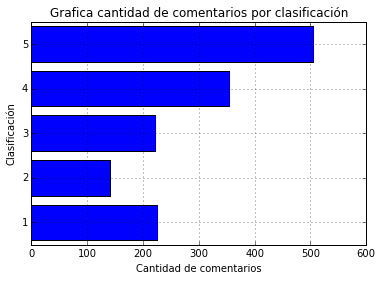

In [4]:
# Se importa la libreria para utilizar plot
# Además se plotea en el própio notebook y no como una ventana nueva
%matplotlib inline
from pylab import *

# Se realiza una gráfica de cantidad de comentarios en función de su clasificación
gruposCalificacion = datos.groupby([u'Calificación']).groups
keyClasificacion = gruposCalificacion.keys()
cantClasificacion = []
for k in keyClasificacion:
    cantClasificacion.append(len(gruposCalificacion.get(k)))    
pos = arange(len(keyClasificacion)) + 0.5 

figure(1)
barh(pos,cantClasificacion, align='center')
yticks(pos, list(keyClasificacion))
xlabel('Cantidad de comentarios')
ylabel(u'Clasificación')
title(u'Grafica cantidad de comentarios por clasificación')
grid(True)
show()

In [5]:
#Se imprime la cantidad de comentarios asociados a cada clase (es decir cantidad de comentarios por calificación)
print ("\nCantidad de comentarios asociados a cada calificación:\n")
print (datos.ix[:,7].value_counts())


Cantidad de comentarios asociados a cada calificación:

5    505
4    354
1    225
3    222
2    141
Name: Calificación, dtype: int64


In [6]:
print ("A continuación se listan los atributos con su tipo asociado:\n")
print (datos.dtypes)

A continuación se listan los atributos con su tipo asociado:

Título          object
Año              int64
Estrellas        int64
Género          object
Duración        object
Reseña          object
ComTexto        object
Calificación     int64
ComFechaHora    object
dtype: object


In [7]:
# Se chequea si los atributos poseen o no valores faltantes
# Para ello se recorren todos los atributos (columnas de 'datos')
for atributo in datos.columns:
    
    # Se obtiene la cantidad de valores distinto de vacio del atributo 
    cantValoresAtributo = datos[atributo].describe()['count']
    
    # Si hay menos que la cantidad de comentarios de 'datos' -> hay valores faltantes
    if(cantComentarios > cantValoresAtributo):
        print ("Hay valores faltantes para el atributo " + atributo)
    else:
        print ("No hay valores faltantes para el tributo " + atributo)

No hay valores faltantes para el tributo Título
No hay valores faltantes para el tributo Año
No hay valores faltantes para el tributo Estrellas
No hay valores faltantes para el tributo Género
No hay valores faltantes para el tributo Duración
No hay valores faltantes para el tributo Reseña
No hay valores faltantes para el tributo ComTexto
No hay valores faltantes para el tributo Calificación
No hay valores faltantes para el tributo ComFechaHora


### 3. Descartamos columnas innecesarias
En esta sección se descartan las columnas (atributos) que se consideran innecesarios. En particular las columnas que creemos se consideran necesarias son solamente las columnas de los comentarios y los puntajes asociados a dichos comentarios. Por lo que se procede a eliminar el resto.

In [8]:
# Se descartan de 'datos' las columnas innecesarias, dejando solamente los comentarios y sus calificaciones
datos.drop(datos.columns[[0,1,2,3,4,5,8]],inplace=True,axis=1)
comentarios_peliculas = datos
# Se imprime un resumen de los datos
print (comentarios_peliculas)

                                               ComTexto  Calificación
0     Muchas gracias, vi online los primeros 4, lueg...             4
1           La mejor serie desde Los Soprano y The Wire             5
2     Llega un punto en el que aburre. Es un plato b...             2
3     En realidad no es una respuesta , es una corre...             1
4     Ahora entiendo menos. El libro en que se basa ...             1
5     Una pena desperdiciar un buen elenco y obviame...             1
6     MAGISTRAL!! excelente la recreación de época. ...             5
7                             es una película mui padre             5
8     EXCELENTE! GENIAL! Esperaba ir a ver con mi hi...             5
9     Muy, muy buena...para grandes y chicos. Tiene ...             5
10    Excelente película, muy original y divertida. ...             5
11    Muy buena película, muy graciosa y de humor ba...             4
12    Muy linda película. La fui a ver con mi hija, ...             4
13    Linda película

### 3. Preprocesamiento de los comentarios
El corpus sobre el cual se trabaja puede contener datos con ruido en su contenido. Es decir, diversos elementos que están mezclados en el contenido pero que además de que no aportan nada a la tarea de clasificación, generan ruido dificultando las tareas posteriores. Para ello entonces se procede a realizar el preprocesamiento de los comentarios.

In [9]:
# Se limpian los datos y se los convierte a una lista de tuplas para su facil manipualacion.
comentarios_peliculas = utl.convert_to_list(utl.depurar_comentarios(comentarios_peliculas))

### 4. Separamos entrenamiento y testeo 
Una vez llegado este punto se divide la lista obtenida en el paso anterior en conjuntos de entrenamiento y testeo, para primero entrenar el algoritmo y luego testearlo.
Para poder entrenar y testear un algoritmo de aprendizaje, como se mencionó, es necesario primero particionar los datos en dos conjuntos disjuntos de entrenamiento y testeo. Se separarán aleatoriamente un 20% de los datos para testeo y el 80% restante se utilizará para el entrenamiento. Para esto se utilizó la función train_test_split del paquete cross_validation de sklearn.

In [10]:
# Se divide el conjunto de datos en train (80%) y test (20%)
datos_train, datos_test = train_test_split(comentarios_peliculas, test_size=0.2)

# Se chequean las cantidades de la división
print (len(datos_train))
print (len(datos_test))

1157
290


### 4. Tokenización NLTK
En esta sección se realiza el proceso de tokenización de los textos utilizando la biblioteca NLTK. Además se convierte a un formato suceptible para la clasificación. Es decir, se tokenizan los comentarios y se calcula el diccionario de palabras frecuentes del mismo. En base a ello y al valor de clasificación asociado se crea una tupla la cual corresponde al comentario analizado. Luego estas tuplas (una por cada comentario) son la entrada para el entrenamiento del algoritmo Entropía Máxima provisto por NLTK.

In [11]:
datos_train_tokenizados_nltk = utl.tokenizar_nltk(datos_train)

#Se imprime el primer comentario tokenizado, cada palabra aparece junto a la cantidad de veces
# que ocurre en el comentario y ademas se imprime la clasificacion del comentario.
print (datos_train_tokenizados_nltk[0])

({'ampliamente': 1, ',': 1, ')': 1, 'rápido': 1, 'recomendable': 1, 'cine': 1, 'fin': 1, 'bien': 1, 'en': 1, 'del': 1, 'tiempos': 1, 'película': 1, 'actuaciones': 1, 'la': 1, 'film': 1, 'las': 1, 'ironía': 1, 'y': 1, 'también': 1, 'estos': 1, 'mega': 1, 'están': 1, 'por': 1, '!': 2, 'musicalización': 1, 'tarde': 1, '(': 1, 'buena': 1, 'furioso': 1, 'eventos': 1, '.': 4, 'de': 2, 'excelente': 1, 'como': 2, 'una': 1, 'muy': 2, 'así': 1, 'socioculturales': 1, 'buen': 1}, 'pos')


### 6. Entrenamiento y evaluación
Una vez de tener los datos en un formato aceptable para los algoritmos de entrenamiento y particionado los mismos en test y train, se procede a realizar el entrenamiento del algoritmo de Máxima Entropía.

In [12]:
# En la siguiente linea se entrena el algoritmo con 8 iteraciones
# Obs. El entrenamiento es bastante lento.
clf_max_ent = nltk.classify.MaxentClassifier.train(datos_train_tokenizados_nltk,max_iter=8)

  ==> Training (8 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.589
             2          -0.80447        0.750
             3          -0.67249        0.814
             4          -0.58510        0.864
             5          -0.52269        0.882
             6          -0.47562        0.890
             7          -0.43870        0.900
         Final          -0.40887        0.909


#### Evaluacion del clasificador con los datos de test
Luego del entrenamiento se procede a evaluar el clasificador con los datos de test, y se obtiene la matriz de confusión para poder analizar claramente los resultados, calculando la accuracy, la precisión, recall y medida F (Esto se realiza en la función getTasa).

In [14]:
#Se imprime la tasa de acierto y la matriz de confucion
datos_test_tokenizado_nltk = utl.tokenizar_nltk(datos_test)
utl.getTasa(clf_max_ent,datos_test_tokenizado_nltk)

Matriz de confusión:
    |   n   n   p |
    |   e   e   o |
    |   g   u   s |
----+-------------+
neg | <39> 16  24 |
neu |   .  <3>  1 |
pos |  28  27<152>|
----+-------------+
(row = reference; col = test)

Accuracy:
0.6689655172413793
Precisión:
	Pos: 0.7342995169082126
	Neu: 0.75
	Neg: 0.4936708860759494
Recall:
	Pos: 0.8587570621468926
	Neu: 0.06521739130434782
	Neg: 0.582089552238806
F-Score:
	Pos: 0.7916666666666667
	Neu: 0.12
	Neg: 0.5342465753424658


Como se puede ver en la matriz de confusión los resultados para las tres clases aún se podrían mejorar, para esto incorporaremos diferentes tipos de features y utilizaremos otras formas de tokenización.

### 7. Incorporación de Features
#### Palabras más frecuentes
En esta sección se busca mejorar el clasificador utilizando como features las palabras más frecuentes, para esto se cuentan las palabras del corpus y se calcula su frecuencia. 
Se utiliza cross-validation para ajustar la cantidad de palabras más frecuentes que se utilizarán para el clasificador. Con el objetivo anterior se definen varias cantidades de palabras y se prueba con cada una de ellas, calculando un promedio del accuracy obtenido en cada iteración del cross-validation.

Obs.: Este proceso demora mucho tiempo en realizarse.

In [ ]:
# Cross valodation para el clasificador
# Frecuencia -1 significa todas las palabras
fecuencias = [-1, 5000, 3000, 2000, 1000, 500]

accuracy_frec_cv = []

for frec in fecuencias:
    print('******************************************************************************')
    print("FRECUENCIA: " + str(frec))
    
    datos_train_frec = utl.filtrar(datos_train, utl.palabras_mas_frecuentes(frec,datos_train), False)
    datos_train_tokenizados = utl.tokenizar_nltk(datos_train_frec)
    
    cv = cross_validation.KFold(len(datos_train_tokenizados), n_folds=10)
    
    accuracy = 0
    for traincv, evalcv in cv:
        classifier = nltk.classify.MaxentClassifier.train(datos_train_tokenizados[traincv[0]:traincv[len(traincv)-1]],max_iter=8,trace=1)
        accuracy += nltk.classify.util.accuracy(classifier, datos_train_tokenizados[evalcv[0]:evalcv[len(evalcv)-1]])
        
    accuracy_avg = (accuracy / 10)
    accuracy_frec_cv += [(frec,accuracy_avg)]
    print('ACCURACY: ' + str(accuracy_avg))
print (accuracy_frec_cv)

Al finalizar el cross-validation, se calcula la cantidad de palabras que tuvo mayor accuracy promedio y se toma dicha cantidad como la cantidad óptima de palabras frecuentes. Una vez obtenido este valor, se filtran los comentarios del corpus de entrenamiento, dejando, para cada comentario, únicamente las palabras que se encuentran dentro de las palabras más frecuentes del corpus.

In [16]:
best_frec = utl.getBestFrec(accuracy_frec_cv)
print("Mejor cantidad de palabras frecuentes: " + str(best_frec))
palabras_mas_frecuentes = utl.palabras_mas_frecuentes(best_frec,datos_train)
datos_train_frec = utl.filtrar(datos_train, palabras_mas_frecuentes, False)

Mejor cantidad de palabras frecuentes: -1


Como se puede observar en el resultado anterior, la variable best_frec obtuvo el valor -1, el cual indica que la cantidad óptima de palabras son todas las palabras del corpus.

Luego, se entrena un nuevo clasificador con el corpus de entrenamiento (comentarios conformados únicamente por las palabras más frecuentes del corpus) y se procede a evaluar el clasificador con el corpus de testeo como se hizo previamente.

In [17]:
datos_train_tokenizados_nltk = utl.tokenizar_nltk(datos_train_frec)
    
classifier = nltk.classify.MaxentClassifier.train(datos_train_tokenizados_nltk,max_iter=8,trace=1)
utl.getTasa(classifier,datos_test_tokenizado_nltk)


  ==> Training (8 iterations)
Matriz de confusión:
    |   n   n   p |
    |   e   e   o |
    |   g   u   s |
----+-------------+
neg | <29>  8   9 |
neu |   .  <2>  1 |
pos |  38  36<167>|
----+-------------+
(row = reference; col = test)

Accuracy:
0.6827586206896552
Precisión:
	Pos: 0.6929460580912863
	Neu: 0.6666666666666666
	Neg: 0.6304347826086957
Recall:
	Pos: 0.943502824858757
	Neu: 0.043478260869565216
	Neg: 0.43283582089552236
F-Score:
	Pos: 0.7990430622009568
	Neu: 0.08163265306122448
	Neg: 0.5132743362831859


Como se puede apreciar en los resultados obtenidos, estos son similares a los anteriores, como era de esperarse.

A partir de este momento, se utilizarán las n palabras más frecuentes, donde n es la mejor cantidad de palabras frecuentes ajustada mediante cross-validation.

#### Elementos subjetivos
A continuación se incorporan como features los elementos subjetivos provistos por los docentes. Para esto se importan desde el archivo "elementos_subjetivos.txt" y se los transforma dejándolos en el mismo formato que el corpus de entrenamiento y se agregan a dicho corpus como comentarios de una única palabra.

In [18]:
elementos_subjetivos = utl.codificarClasificacionesSubjetivos(utl.diccionarioElementosSubjetivos("elementos_subjetivos.txt"))

In [19]:
features_nltk = datos_train_tokenizados_nltk + elementos_subjetivos

Se entrena un clasificador con el nuevo corpus de entrenamiento y se procede a la evaluación de dicho clasificador con el corpus de testeo.

In [20]:
classifier = nltk.classify.MaxentClassifier.train(features_nltk,max_iter=8,trace=1)
utl.getTasa(classifier,datos_test_tokenizado_nltk)

  ==> Training (8 iterations)
Matriz de confusión:
    |   n   n   p |
    |   e   e   o |
    |   g   u   s |
----+-------------+
neg | <28> 11  13 |
neu |   .  <2>  1 |
pos |  39  33<163>|
----+-------------+
(row = reference; col = test)

Accuracy:
0.6655172413793103
Precisión:
	Pos: 0.6936170212765957
	Neu: 0.6666666666666666
	Neg: 0.5384615384615384
Recall:
	Pos: 0.9209039548022598
	Neu: 0.043478260869565216
	Neg: 0.417910447761194
F-Score:
	Pos: 0.79126213592233
	Neu: 0.08163265306122448
	Neg: 0.47058823529411764


Como se puede apreciar en los resultados obtenidos, estos vuelven a ser similares a los anteriores.

### 8. Tokenización Freeling
Ahora se procede a realizar la tokenización utilizando Freeling.

Según nuestras observaciones el resultado de esta tokenización es muy similar al obtenido durante la tokenización con NLTK, pero es posible que la tokenización con Freeling sea más precisa, debido a que es una herramienta que está hecha específicamente para el idioma español.

Para probar la tokenización con Freeling, se agregaron al corpus de entrenamiento las mismas features que anteriormente (palabras más frecuentes y elementos subjetivos).

In [21]:
datos_train_tokenizados_freeling = utl.tokenizar_freeling(datos_train_frec)
datos_test_tokenizados_freeling = utl.tokenizar_freeling(datos_test)

features_freeling = datos_train_tokenizados_freeling + elementos_subjetivos

classifier = nltk.classify.MaxentClassifier.train(features_freeling,max_iter=8,trace=1)
utl.getTasa(classifier,datos_test_tokenizados_freeling)

  ==> Training (8 iterations)
Matriz de confusión:
    |   n   n   p |
    |   e   e   o |
    |   g   u   s |
----+-------------+
neg | <30> 11  13 |
neu |   .  <2>  . |
pos |  37  33<164>|
----+-------------+
(row = reference; col = test)

Accuracy:
0.6758620689655173
Precisión:
	Pos: 0.7008547008547008
	Neu: 1.0
	Neg: 0.5555555555555556
Recall:
	Pos: 0.9265536723163842
	Neu: 0.043478260869565216
	Neg: 0.44776119402985076
F-Score:
	Pos: 0.7980535279805352
	Neu: 0.08333333333333333
	Neg: 0.4958677685950414


### 9. POS-tagging
El siguiente paso en nuestra investigación es repetir el proceso anterior pero agregando información de POS-tagging.

Esta información agregada la utilizamos para descartar tipos de palabras que no afectan a la hora de clasificar un comentario, como podrían ser los artículos, los nombres, etc.

Luego de esto, se entrena un nuevo clasificador y se evalúa su accuracy.

Obs.: En la función POS_tagging se encuentra las etiquetas EAGLES utilizadas para la selección de las features.


In [1]:
from subprocess import Popen, PIPE, STDOUT
datos_train_tokenizados_pos_tagging = utl.POS_tagging(datos_train_frec)
datos_test_tokenizados_pos_tagging = utl.POS_tagging(datos_test)

features_pos_tagging = datos_train_tokenizados_pos_tagging + elementos_subjetivos

classifier = nltk.classify.MaxentClassifier.train(features_pos_tagging,max_iter=8,trace=1)
utl.getTasa(classifier,datos_test_tokenizados_pos_tagging)

NameError: name 'utl' is not defined

Si bien el accuracy de la última ejecución fue inferior al escenario anterior, en promedio, al agregar información de POS-tagging la accuracy del clasificador mejoró, debido a que esto permitió ser más riguroso con la selección de las features.

En las pruebas realizadas los valores oscilaron entre 0.67 y 0.74.

### 10. Incorporación de otras features
Para intentar mejorar nuestro clasificador incorporamos otras features. Las features agregadas fueron:

- Términos no valorativos del ámbito del cine: Palabras que se pueden encontrar en un comentario sobre una película pero que no aportan a la hora de clasificar dicho comentario.
- Caracteres especiales y signos de puntuación: Al ver las palabras más frecuentes del corpus, nos encontramos con que las palabras más frecuentes eran siempre signos de puntuación como ("!", ".", ",", etc), por lo que pensamos que se podría mejorar la precisión descartándolos.
- Stopwords: Stopwords del español provistas por NLTK.


Luego de la incorporación de estas features, se vuelve a probar con las tres opciones de tokenización previamente utilizadas (NLTK, Freeling, con información de POS-tagging), y verificar si se mejora la precisión con estas incorporaciones.


In [23]:
dominio_cine_peliculas = open('terminosNoValorativosAmbitoCine.txt').read()
caracteres_especiales = open('caracteres_especiales.txt').read()
nltk_stopwords = stopwords.words('spanish')

datos_train_frec = utl.filtrar(datos_train_frec, nltk_stopwords, True)
datos_train_frec = utl.filtrar(datos_train_frec, caracteres_especiales, True)
datos_train_frec = utl.filtrar(datos_train_frec, dominio_cine_peliculas, True)

#### NLTK

In [24]:
datos_train_tokenizados_nltk = utl.tokenizar_nltk(datos_train_frec)
datos_test_tokenizado_nltk = utl.tokenizar_nltk(datos_test)

features_nltk = datos_train_tokenizados_nltk + elementos_subjetivos

classifier = nltk.classify.MaxentClassifier.train(datos_train_tokenizados_nltk,max_iter=8,trace=1)
utl.getTasa(classifier,datos_test_tokenizado_nltk)

  ==> Training (8 iterations)
Matriz de confusión:
    |   n   n   p |
    |   e   e   o |
    |   g   u   s |
----+-------------+
neg | <30>  7   8 |
neu |   6  <9>  4 |
pos |  31  30<165>|
----+-------------+
(row = reference; col = test)

Accuracy:
0.7034482758620689
Precisión:
	Pos: 0.7300884955752213
	Neu: 0.47368421052631576
	Neg: 0.6666666666666666
Recall:
	Pos: 0.9322033898305084
	Neu: 0.1956521739130435
	Neg: 0.44776119402985076
F-Score:
	Pos: 0.8188585607940446
	Neu: 0.2769230769230769
	Neg: 0.5357142857142857


#### Freeling

In [ ]:
#FREELING
datos_train_tokenizados_freeling = utl.tokenizar_freeling(datos_train_frec)
datos_test_tokenizados_freeling = utl.tokenizar_freeling(datos_test)

features_freeling = datos_train_tokenizados_freeling + elementos_subjetivos

classifier = nltk.classify.MaxentClassifier.train(features_freeling,max_iter=8,trace=1)
utl.getTasa(classifier,datos_test_tokenizados_freeling)

  ==> Training (8 iterations)
Matriz de confusión:
    |   n   n   p |
    |   e   e   o |
    |   g   u   s |
----+-------------+
neg | <43> 12  20 |
neu |   .  <5>  2 |
pos |  24  29<155>|
----+-------------+
(row = reference; col = test)

Accuracy:
0.7
Precisión:
	Pos: 0.7451923076923077
	Neu: 0.7142857142857143
	Neg: 0.5733333333333334
Recall:
	Pos: 0.8757062146892656
	Neu: 0.10869565217391304
	Neg: 0.6417910447761194
F-Score:
	Pos: 0.8051948051948052
	Neu: 0.18867924528301885
	Neg: 0.6056338028169014


#### POS-tagging

In [ ]:
#POS-tagging
datos_train_tokenizados_pos_tagging = utl.POS_tagging(datos_train_frec)
datos_test_tokenizados_pos_tagging = utl.POS_tagging(datos_test)

features_POS_tagging = datos_train_tokenizados_pos_tagging + elementos_subjetivos

classifier = nltk.classify.MaxentClassifier.train(features_POS_tagging,max_iter=8,trace=1)
utl.getTasa(classifier,datos_test_tokenizados_pos_tagging)

In [ ]:
print("END: " + str(datetime.datetime.now()))

### 11. Conclusiones

En base a los resultados obtenidos, si bien estos son aceptables, creemos que podrían ser mejorados aún más. Según el análisis realizado sobre corpus este presenta una disparidad en la distribución de comentarios por cada clase, esto sumado a que el corpus es relativamente pequeño afectó mayoritariamente de forma negativa a la clasificación de los comentarios neutros.

Evaluando la media de los resultados obtenidos en base a los distintos clasificadores creados, creemos que el clasificador elaborado se comporta satisfactoriamente, especialmente teniendo en cuenta que los seres humanos se ponen de acuerdo en la valoración en aproximadamente el 80% de los casos (http://sentdex.com/sentiment-analysis/), además teniendo en cuenta que un clasificador aleatorio obtendría un 33% de accuracy ya que la probabilidad de etiquetar un comentario correctamente es de un tercio.

Por otro lado, el clasificador que obtuvo mejores resultados fue el que se entrenó con el corpus tokenizado con Freeling agregando información de POS-tagging e incorporando las palabras más frecuentes y los elementos subjetivos.

#### Posibles mejoras

Como mencionamos anteriormente hay algunos problemas que se podrían ver solucionados incorporando algunas mejoras.
Por ejemplo en el corpus: 

- Contar con ejemplos que estén distribuidos homogéneamente para poder mejorar las clasificaciones de comentarios según su clase.
- Contar con una lista de elementos subjetivos mejorada que esté más relacionada con el ámbito del cine.
- Utilizar otro tipo de clasificador para realizar la clasificación de los comentarios y poder realizar un análisis comparativo de los mismos. Entre ellos se podrían utilizar Naive Bayes, Árboles de Decisión, entre otros.


#### Integrantes

- Federico Kauffman, 4.580.929-7
- Martín Steglich, 4.607.084-9
- Sergio Bonilla, 4.430.955-3
- Martín Méndez, 5.163.637-9